In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp
import os
from dotenv import load_dotenv
import sys
import pymysql
# 상위 폴더(../)에 있는 `.env` 파일 로드
dotenv_path = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".env"))
load_dotenv(dotenv_path)

## mysql 연결
mysql_url = f"jdbc:mysql://{os.getenv('host_ip')}:3306/{os.getenv('DATABASE')}?useSSL=false&allowPublicKeyRetrieval=true&useUnicode=true&characterEncoding=UTF-8"


In [2]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/local/lib/mysql-connector-java-5.1.49.jar pyspark-shell'
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# SparkSession 생성
spark = SparkSession.builder \
    .appName("Analytics") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

25/02/06 16:36:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
df = spark.read.format('jdbc')\
                .options(
                    url = mysql_url
                    , driver = 'com.mysql.jdbc.Driver'
                    , dbtable = 'tbCrawled_Youtube'
                    , user = os.getenv('user_id')
                    , password = os.getenv('user_password')
                        )\
            .load()

In [4]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF

# 1. 텍스트 토큰화
tokenizer = Tokenizer(inputCol="comment", outputCol="words")
tmp_df = tokenizer.transform(df)

# 2. 불용어 제거
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
tmp_df = stopwords_remover.transform(tmp_df)
tmp_df

# 3. CountVectorizer를 사용하여 단어를 벡터로 변환
cv = CountVectorizer(inputCol="filtered_words", outputCol="features")
cv_model = cv.fit(tmp_df)
tmp_df = cv_model.transform(tmp_df)
tmp_df

# 4. TF-IDF 적용
idf = IDF(inputCol="features", outputCol="tfidf_features")
idf_model = idf.fit(tmp_df)
tmp_df = idf_model.transform(tmp_df)
tmp_df

25/02/06 16:36:50 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
                                                                                

DataFrame[id: int, video_id: string, title: string, publish_date: timestamp, channel_name: string, comment: string, like_count: int, comment_publish_date: timestamp, inserted_at: timestamp, words: array<string>, filtered_words: array<string>, features: vector, tfidf_features: vector]

In [63]:
tmp_df.select('comment', 'tfidf_features').show(truncate = False)

+---------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|comment                                                                                                        |tfidf_features                                                                                                                                                                                                                                                                                                                                                                   |
+-------------------------------

25/02/06 15:50:32 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


In [64]:
from pyspark.ml.clustering import KMeans

# KMeans 모델 생성 (K=2: 긍정/부정)
kmeans = KMeans(k=2, featuresCol="tfidf_features", predictionCol="cluster")
model = kmeans.fit(tmp_df)

# 예측 수행
tmp_df = model.transform(tmp_df)

tmp_df.select("comment", "cluster").show()


25/02/06 15:50:36 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:50:41 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:50:41 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:50:41 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:50:41 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:50:42 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:50:42 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:50:42 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:50:43 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:50:43 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:50:43 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
25/02/06 15:50:46 WARN DAGScheduler: Broadcasting larg

+-----------------------------------+-------+
|                            comment|cluster|
+-----------------------------------+-------+
|  영상 내용엔 없지만 일반모델이 ...|      0|
|    일반을 살꺼면 애플을 머하러사노|      0|
|     이번엔... 야간촬영 빛번짐.....|      0|
| 사람 감각기관이 웃긴게 프로모션...|      0|
|       이쯤 되면 일반형에 120HZ ...|      0|
|  인트로 기획이 내용 기획보다 오...|      0|
|               85300 ㅋㅋㅋㅋㅋㅋㅋ|      0|
|            Itsub(85,600) ㅋㅋㅋ...|      0|
|  아이폰이 갤럭시에 비해 망원 카...|      0|
| 리뷰 보니 카메라버튼 무쓸모네요...|      0|
|   노트9에서 울트라22로 바꿧엇는...|      0|
|  저 버튼을 캡쳐용도로 바꿀수는 ...|      0|
|  아주 작은 차이는 누군가에겐 크...|      0|
| 스티브라면 카메라 버튼 추가하지...|      0|
| 휴대폰에 예전처럼 외장메모리 넣...|      0|
|  이십다섯배 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ|      0|
|    저분 26까지 또 버티는거 아녜...|      0|
|카메라좀 확 업글점 하지 맨날 조끔씩|      0|
|    역시 잇섭님 영상! 귀에 쏙쏙 ...|      0|
|    아따 ...존버충들 환호할 영상...|      0|
+-----------------------------------+-------+
only showing top 20 rows



25/02/06 15:51:02 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


In [65]:
# 각 클러스터의 개수 확인
tmp_df.groupBy("cluster").count().show()

# 클러스터별 샘플 확인
tmp_df.filter(tmp_df["cluster"] == 0).show(truncate=False)  # 첫 번째 클러스터 (예: 긍정)
tmp_df.filter(tmp_df["cluster"] == 1).show(truncate=False)  # 두 번째 클러스터 (예: 부정)
#tmp_df.filter(tmp_df["cluster"] == 2).show(truncate=False)  # 3번째 클러스터


25/02/06 15:51:05 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
25/02/06 15:51:08 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
25/02/06 15:51:08 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
25/02/06 15:51:09 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
25/02/06 15:51:11 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
25/02/06 15:51:18 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
                                                                                

+-------+-----+
|cluster|count|
+-------+-----+
|      1|    2|
|      0|93351|
+-------+-----+



25/02/06 15:51:23 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
                                                                                

+---+-----------+--------------------------------------------------------------------------------+-------------------+------------+---------------------------------------------------------------------------------------------------------------+----------+--------------------+-------------------+--------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

25/02/06 15:51:24 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
                                                                                

+-----+-----------+--------------------------------------------------------------------------+-------------------+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

25/02/06 15:51:27 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
[Stage 508:>                                                        (0 + 1) / 1]

+---+--------+-----+------------+------------+-------+----------+--------------------+-----------+-----+--------------+--------+--------------+-------+
|id |video_id|title|publish_date|channel_name|comment|like_count|comment_publish_date|inserted_at|words|filtered_words|features|tfidf_features|cluster|
+---+--------+-----+------------+------------+-------+----------+--------------------+-----------+-----+--------------+--------+--------------+-------+
+---+--------+-----+------------+------------+-------+----------+--------------------+-----------+-----+--------------+--------+--------------+-------+



In [66]:
tmp_df.createOrReplaceTempView('tmp')

In [71]:
spark.sql('''
select
id
, cluster

from
tmp
where cluster = 1
''')\
.show(truncate = False)

25/02/06 15:52:43 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
[Stage 513:>                                                        (0 + 1) / 1]

+-----+-------+
|id   |cluster|
+-----+-------+
|25802|1      |
|54691|1      |
+-----+-------+



In [57]:
# 가장 많이 등장한 단어 확인 (긍정/부정 키워드 확인)
cv_model.vocabulary[:50]  # 상위 50개 단어 출력


['',
 '너무',
 '아이폰',
 '진짜',
 '더',
 '잘',
 '그냥',
 '울트라',
 '갤럭시',
 '좀',
 'ㅋㅋ',
 '카메라',
 '다',
 '많이',
 '영상',
 'ㅋㅋㅋ',
 '왜',
 '삼성',
 '것',
 '수',
 '근데',
 '이제',
 '이번에',
 '안',
 '저는',
 '정말',
 '쓰고',
 '보고',
 's24',
 '16',
 '좋은',
 '프로',
 'ㅎㅎ',
 '폰',
 'ㅠㅠ',
 '이',
 '이번',
 '저도',
 '애플',
 '지금',
 '그',
 '리뷰',
 '있는데',
 '전',
 'ㅋㅋㅋㅋ',
 '그리고',
 '일반',
 '배터리',
 '16프로',
 '저']

25/02/06 15:45:06 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:45:11 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:45:12 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:45:12 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:45:12 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:45:12 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:45:13 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:45:13 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:45:13 WARN BlockManager: Asked to remove block broadcast_74, which does not exist
25/02/06 15:45:13 WARN BlockManager: Asked to remove block broadcast_74_piece0, which does not exist
25/02/06 15:45:13 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/02/06 15:45:13 WARN DAGSched

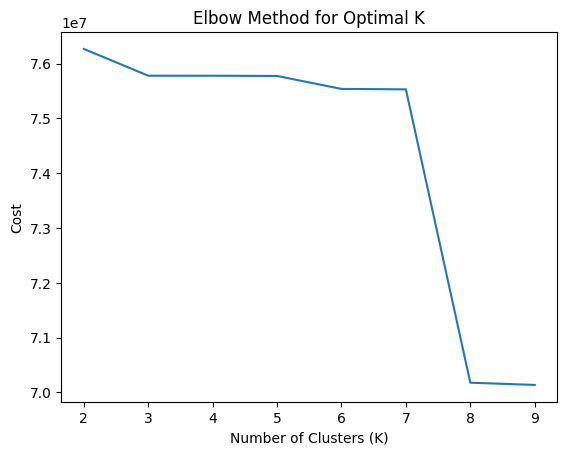

In [60]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import ClusteringEvaluator

cost = []
for k in range(2, 10):  # K를 2~10으로 조정
    kmeans = KMeans(k=k, featuresCol="tfidf_features", predictionCol="cluster_try2")
    model = kmeans.fit(tmp_df)
    cost.append(model.summary.trainingCost)

# 엘보우 그래프 시각화
plt.plot(range(2, 10), cost)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost")
plt.title("Elbow Method for Optimal K")
plt.show()


In [ ]:
evaluator = ClusteringEvaluator(featuresCol="tfidf_features")

for k in range(2, 6):
    kmeans = KMeans(k=k, featuresCol="tfidf_features", predictionCol="cluster")
    model = kmeans.fit(tmp_df)
    predictions = model.transform(tmp_df)
    
    score = evaluator.evaluate(predictions)
    print(f"K={k}, Silhouette Score={score}")


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 한국어 감성 분석 모델 (모델 종류: KoBERT, KcBERT 등)
model_name = "snunlp/KR-FinBERT-SC"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 감성 분석 함수 정의
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = ["negative", "neutral", "positive"]
    return labels[torch.argmax(probs)], probs.max().item()

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType

# 감성 분석 UDF 정의
def sentiment_analysis_udf(text):
    label, confidence = predict_sentiment(text)
    return label

def confidence_udf(text):
    label, confidence = predict_sentiment(text)
    return confidence

# UDF 등록
sentiment_udf = udf(sentiment_analysis_udf, StringType())
confidence_udf = udf(confidence_udf, FloatType())

# 감성 분석 적용
tmp_df = tmp_df.withColumn("sentiment", sentiment_udf(tmp_df["comment"]))
tmp_df = tmp_df.withColumn("confidence", confidence_udf(tmp_df["comment"]))

tmp_df.show()


/home/ubuntu/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
25/02/06 16:37:24 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
[Stage 5:>                                                          (0 + 1) / 1]

+---+-----------+---------------------------------+-------------------+------------+-----------------------------------+----------+--------------------+-------------------+------------------------------------+------------------------------------+--------------------+--------------------+---------+----------+
| id|   video_id|                            title|       publish_date|channel_name|                            comment|like_count|comment_publish_date|        inserted_at|                               words|                      filtered_words|            features|      tfidf_features|sentiment|confidence|
+---+-----------+---------------------------------+-------------------+------------+-----------------------------------+----------+--------------------+-------------------+------------------------------------+------------------------------------+--------------------+--------------------+---------+----------+
|  1|cdiVvaq6UO4|무조건 아이폰 프로만 고집했던 ...|2024-09-17 04:00:12|   ITSub잇섭| 

In [7]:
tmp_df.createOrReplaceTempView('tmp2')

In [ ]:
spark.sql('''
select
id
, sentiment
, confidence from
tmp2
''').show()

[Stage 6:>                                                          (0 + 1) / 1]

In [2]:
import sys
print(sys.executable)


/home/ubuntu/anaconda3/envs/pytorch_p39/bin/python


In [4]:
!jupyter kernelspec list


Available kernels:
  python3        /home/ubuntu/anaconda3/envs/Project/share/jupyter/kernels/python3
  airflow_p38    /home/lab13/.local/share/jupyter/kernels/airflow_p38
  crawling       /home/lab13/.local/share/jupyter/kernels/crawling
  project        /home/lab13/.local/share/jupyter/kernels/project
  pytorch_p38    /home/lab13/.local/share/jupyter/kernels/pytorch_p38
  pytorch_p39    /home/lab13/.local/share/jupyter/kernels/pytorch_p39


In [5]:
spark.stop()

NameError: name 'spark' is not defined